In [23]:
#import modules needed to handle data and encoding
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import pickle
import dalex as dx

class Model:
    def __init__(self, datafile, target):
        #initialization class object, and also creating the target dataset
        self.df = pd.read_csv(datafile)
        self.y=self.df[target]
        encoder = LabelEncoder()
        encoder.fit(self.y)
        new_data = encoder.transform(self.y)
        new_data.reshape(-1,1)
        self.y=new_data
            
    #create data frame with features, drop columns which are unnecessary or are target
    def create_X(self, column):
        self.X = self.df.drop(columns=column)
    
    #function which normalize categories number; for more than 4 categories in one column 
    #it calculates percentage value and for less than 5.5% category name is replaced with 'other'
    def categories_normalization(self):
        for column in self.X.columns:
            if self.X[column].nunique()>4:
                cat = self.X[column].unique()
                number_for_cat = self.X[column].value_counts()
                data_len = len(self.X[column])
                list_to_replace = []
                for i in range(len(cat)):
                    cat_in_perc = round(number_for_cat[i]/data_len*100, 2)
                    if cat_in_perc <= 5.5:
                        list_to_replace.append(cat[i])
                    else:
                        pass
                self.X[column].replace(to_replace=list_to_replace, value='other', inplace=True)
            else:
                pass

    #function which takes data frame, column name and scaler name and return data frame 
    #with encoded column using specified scaler, dropping original column        
    def data_scaler(self, column_header, scaler_name):
        column = np.array(self.X[column_header]).reshape(-1,1)
        scaler = scaler_name()
        scaler.fit(column)
        new_data = scaler.transform(column)
        self.X[column_header + "_scal"] = pd.Series(new_data[:,0])
        self.X.drop(columns=column_header, inplace=True)
    
    #function which takes data frame, column name and encoder name and return data frame 
    #with encoded column using specified encoder, dropping original column  
    def data_encoder(self, encoding_function_name):
        for column in self.X.columns:
            if encoding_function_name==OneHotEncoder:
                column_ = np.array(self.X[column]).reshape(-1,1)
                encoder = encoding_function_name(sparse=False)
                encoder.fit(column_)
                categories = encoder.categories_
                new_data = encoder.transform(column_)
                for i in range(len(categories[0])):
                    self.X[column + "_" + categories[0][i]] = pd.Series(new_data[:,i])
                self.X.drop(columns=column, inplace=True)
            elif encoding_function_name==LabelEncoder:
                column_ = self.X[column]
                encoder = encoding_function_name()
                encoder.fit(column_)
                new_data = encoder.transform(column_)
                new_data.reshape(-1,1)
                self.X[column + "_enc"] = pd.Series(new_data)
                self.X.drop(columns=column, inplace=True)
            elif encoding_function_name==OrdinalEncoder:
                column_ = np.array(self.X[column]).reshape(-1,1)
                encoder = encoding_function_name()
                encoder.fit(column_)
                new_data = encoder.transform(column_)
                self.X[column + "_enc"] = pd.Series(new_data[:,0])
                self.X.drop(columns=column, inplace=True)
            else:
                print("Encoder is not specified in function")
    

    #function for choosing type of model and initialization of model
    #optionally params dict with key, values can be used for specific model
    def choose_model(self, model_type=None, params={}): 
        if model_type=='rf':
            self.user_defined_model = RandomForestClassifier(**params)
        elif model_type=='lg':
            self.user_defined_model = LogisticRegression(**params)
        elif model_type=='svc':
            self.user_defined_model = SVC(kernel='rbf', **params)
        elif model_type=='dt':
            self.user_defined_model = DecisionTreeClassifier(**params)
        elif model_type=='knn':
            self.user_defined_model = KNeighborsClassifier(**params)
        else:
            self.user_defined_model = RandomForestClassifier(**params)
    

    #function which split the target and features into test and training datasets, as inputs it get target, features and test_size
    def split(self, test_size):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = test_size, random_state = 42, shuffle=True)

    #function for training model, which takes the training datasets
    def fit(self):
        self.model = self.user_defined_model.fit(self.X_train, self.y_train)
        
    
    #function for predictions, takes the test datasets
    def predict(self):
        self.result = self.model.predict(self.X_test)

    #function which allows identifying best parameters for specified model
    def grid_search_best(self, params={}):
        grid_search = GridSearchCV(self.user_defined_model, param_grid=params, cv=5, verbose=1)
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_params_
    
    #function which incorporates other functions used for modelling: fit, predict and score - run one function instead of 3
    def run_model(self):
        self.fit()
        self.predict()
        self.score()
    
    #checking score of chosen model for test and train data
    def score(self):
        m_score_train= self.model.score(self.X_train,self.y_train)
        m_score_test = self.model.score(self.X_test, self.y_test)
        f1_score_train = f1_score(self.y_train,self.model.predict(self.X_train))
        f1_score_test = f1_score(self.y_test,self.model.predict(self.X_test))
        return print( f"Accuracy score for train set is {m_score_train}\nAccuracy score for test set is {m_score_test}\nF1 score for train set is {f1_score_train}\nF1 score for test set is {f1_score_test}\n")  

    #function for confusion matrix and classification report
    def matrix(self):
        conf_matrix=confusion_matrix(self.y_test,self.result)
        class_report=classification_report(self.y_test,self.result)
        sns.heatmap(confusion_matrix(self.y_test, self.result), annot = True)
        return print(f"Confusion matrix: \n {conf_matrix} \nClassification report: \n{class_report}")
    
    #function which allows saving parameters and model information to external csv file also packs model info into 
    #pickle file and store is under 'pickles' folder
    def save_model(self, header=False):
        model_name = self.user_defined_model
        model_params = self.model.get_params()
        model_acc_scores = (self.model.score(self.X_train, self.y_train), self.model.score(self.X_test, self.y_test))
        model_f1_scores = (f1_score(self.y_train, self.model.predict(self.X_train)), f1_score(self.y_test, self.model.predict(self.X_test)))
        results = pd.DataFrame({'model': [model_name], 'model_params': [model_params], 'accuracy':[model_acc_scores],'f1':[model_f1_scores]})
        with open(f'pickles/{model_name}.pkl', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return results.to_csv("model_results.csv", mode='a', index=False, header=header)
    
    #function which allows visualize feature importance
    def model_explore(self):
        explainer = dx.Explainer(self.user_defined_model, self.X_train, self.y_train)
        explanation = explainer.model_parts()
        return explanation.result, explanation.plot()
#         explainer.predict_parts(self.model.predict(self.X_train)).result, explainer.predict_parts(self.model.predict(self.X_train)).plot()
 

Accuracy score for train set is 0.9787659639944607
Accuracy score for test set is 0.9667692307692307
F1 score for train set is 0.9776554404145078
F1 score for test set is 0.9648437500000001

Confusion matrix: 
 [[830  13]
 [ 41 741]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       843
           1       0.98      0.95      0.96       782

    accuracy                           0.97      1625
   macro avg       0.97      0.97      0.97      1625
weighted avg       0.97      0.97      0.97      1625



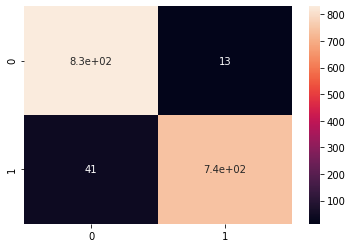

In [40]:
#Random forest model
model_rf=Model("mushrooms.csv","class")
model_rf.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor", "population"])
model_rf.categories_normalization()
model_rf.data_encoder(OneHotEncoder)
model_rf.choose_model('rf', params = {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 50})
model_rf.split(0.2)
model_rf.run_model()
model_rf.matrix()

In [41]:
model_rf.grid_search_best(params={"max_depth": [3, 10, 12],
               "n_estimators":[10, 50, 100],
               "min_samples_leaf":[1, 2, 25],
               "max_features":[2, 4, 'auto']})

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [42]:
model_rf.save_model(header=True)

In [43]:
model_rf.model_explore()

Preparation of a new explainer is initiated

  -> data              : 6499 rows 24 cols
  -> target variable   : 6499 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000294CD69F048> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.482, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.924, mean = 0.000351, max = 0.716
  -> model_info        : package sklearn

A new explainer has been created!


(           variable  dropout_loss                   label
 0      _full_model_      0.002490  RandomForestClassifier
 1     cap-surface_g      0.002514  RandomForestClassifier
 2     ring-number_n      0.002528  RandomForestClassifier
 3       cap-color_g      0.002839  RandomForestClassifier
 4       cap-shape_s      0.002925  RandomForestClassifier
 5   cap-shape_other      0.002952  RandomForestClassifier
 6       cap-shape_x      0.003299  RandomForestClassifier
 7   cap-color_other      0.003362  RandomForestClassifier
 8       cap-color_e      0.003449  RandomForestClassifier
 9       cap-shape_f      0.003859  RandomForestClassifier
 10    ring-number_t      0.004074  RandomForestClassifier
 11      cap-color_w      0.004230  RandomForestClassifier
 12    ring-number_o      0.004289  RandomForestClassifier
 13      cap-shape_b      0.004517  RandomForestClassifier
 14    cap-surface_f      0.004624  RandomForestClassifier
 15    cap-surface_y      0.005109  RandomForestClassifi

Accuracy score for train set is 0.8965881111501934
Accuracy score for test set is 0.8900738310090238
F1 score for train set is 0.8915129151291513
F1 score for test set is 0.8842832469775476

Confusion matrix: 
 [[1146  111]
 [ 157 1024]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1257
           1       0.90      0.87      0.88      1181

    accuracy                           0.89      2438
   macro avg       0.89      0.89      0.89      2438
weighted avg       0.89      0.89      0.89      2438



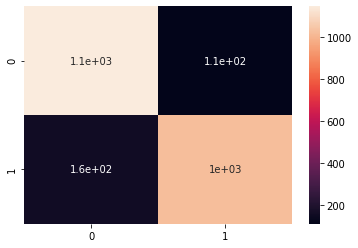

In [46]:
#Logistic regression model
model_lr=Model("mushrooms.csv","class")
model_lr.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor", "population"])
model_lr.categories_normalization()
model_lr.data_encoder(OneHotEncoder)
model_lr.choose_model('lg', params={'C': 1, 'penalty': 'l2', 'random_state': 1})
model_lr.split(0.3)
model_lr.run_model()
model_lr.matrix()

In [45]:
model_lr.grid_search_best(params={"penalty": ['l1', 'l2'],
               "C":[0.1, 0.3, 1],
               "random_state":[1, 2, 25]})

Fitting 5 folds for each of 18 candidates, totalling 90 fits


E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.


E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning:

Estimator fit failed. The score on this train-test parti

E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.


E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning:

Estimator fit failed. The score on this train-test parti

E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.


E:\Anaconda\envs\notebook\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning:

Estimator fit failed. The score on this train-test parti

E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

E:\Anaconda\envs\notebook\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

E:\Anaconda\envs\notebook\lib\site-packa

{'C': 1, 'penalty': 'l2', 'random_state': 1}

In [47]:
model_lr.save_model()

In [48]:
model_lr.model_explore()

Preparation of a new explainer is initiated

  -> data              : 5686 rows 24 cols
  -> target variable   : 5686 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000294CD69F048> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000362, mean = 0.481, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.99, mean = -2.9e-07, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


(           variable  dropout_loss               label
 0       cap-color_g      0.064344  LogisticRegression
 1     ring-number_o      0.064556  LogisticRegression
 2       cap-shape_b      0.064569  LogisticRegression
 3      _full_model_      0.064575  LogisticRegression
 4     cap-surface_s      0.064669  LogisticRegression
 5     stalk-shape_e      0.064722  LogisticRegression
 6     cap-surface_g      0.064760  LogisticRegression
 7       cap-color_y      0.064768  LogisticRegression
 8     stalk-shape_t      0.064830  LogisticRegression
 9     ring-number_n      0.064878  LogisticRegression
 10      cap-shape_s      0.065496  LogisticRegression
 11    ring-number_t      0.065775  LogisticRegression
 12    cap-surface_y      0.065819  LogisticRegression
 13  cap-shape_other      0.067727  LogisticRegression
 14      cap-color_e      0.069300  LogisticRegression
 15      cap-color_w      0.070185  LogisticRegression
 16  cap-color_other      0.072987  LogisticRegression
 17      c

Accuracy score for train set is 0.9839957791065775
Accuracy score for test set is 0.9700574241181296
F1 score for train set is 0.9832072338069755
F1 score for test set is 0.968548039638087

Confusion matrix: 
 [[1241   16]
 [  57 1124]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1257
           1       0.99      0.95      0.97      1181

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438



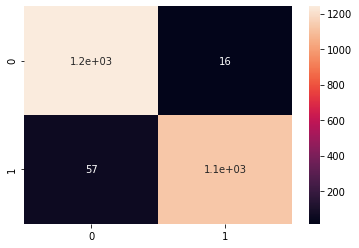

In [50]:
#SVC rbf model
model_svc=Model("mushrooms.csv","class")
model_svc.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor"])
model_svc.categories_normalization()
model_svc.data_encoder(OneHotEncoder)
model_svc.choose_model('svc', params={'C': 7, 'gamma': 'scale'})
model_svc.split(0.3)
model_svc.run_model()
model_svc.matrix()

In [49]:
model_svc.grid_search_best(params={'gamma':['scale', 'auto'],
            'C':list(range(1,10,1)),
           })

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'C': 7, 'gamma': 'scale'}

In [51]:
model_svc.model_explore()

Preparation of a new explainer is initiated

  -> data              : 5686 rows 28 cols
  -> target variable   : 5686 values
  -> model_class       : sklearn.svm._classes.SVC (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x00000294CD69F0D8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.472, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.00897, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


(            variable  dropout_loss label
 0       population_a      0.016011   SVC
 1       _full_model_      0.016011   SVC
 2      ring-number_o      0.016011   SVC
 3       population_n      0.016011   SVC
 4        cap-color_e      0.016011   SVC
 5        cap-color_g      0.016011   SVC
 6      cap-surface_g      0.016011   SVC
 7      cap-surface_f      0.016011   SVC
 8       population_s      0.016157   SVC
 9    cap-shape_other      0.016375   SVC
 10       cap-color_y      0.016748   SVC
 11       cap-shape_x      0.017029   SVC
 12     ring-number_n      0.018125   SVC
 13       cap-shape_s      0.018362   SVC
 14       cap-shape_b      0.019998   SVC
 15     cap-surface_y      0.022859   SVC
 16   cap-color_other      0.023419   SVC
 17       cap-shape_f      0.023826   SVC
 18  population_other      0.039865   SVC
 19     stalk-shape_e      0.044695   SVC
 20     stalk-shape_t      0.044783   SVC
 21     ring-number_t      0.049080   SVC
 22    gill-spacing_w      0.05047

Accuracy score for train set is 0.9836440379880408
Accuracy score for test set is 0.9700574241181296
F1 score for train set is 0.982831825733801
F1 score for test set is 0.968548039638087

Confusion matrix: 
 [[1241   16]
 [  57 1124]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1257
           1       0.99      0.95      0.97      1181

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438



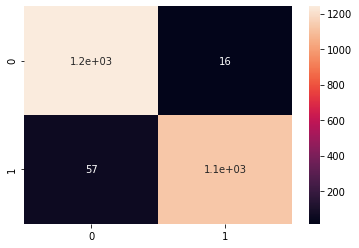

In [53]:
#KNN  model
model_knn=Model("mushrooms.csv","class")
model_knn.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor"])
model_knn.categories_normalization()
model_knn.data_encoder(OneHotEncoder)
model_knn.choose_model('knn', params = {'leaf_size': 1, 'n_neighbors': 7})
model_knn.split(0.3)
model_knn.run_model()
model_knn.matrix()

In [52]:
model_knn.grid_search_best(params={'n_neighbors':list(range(1,10,1)),
            'leaf_size':list(range(1,101,10)),
           })

Fitting 5 folds for each of 90 candidates, totalling 450 fits


{'leaf_size': 1, 'n_neighbors': 7}

In [54]:
model_knn.model_explore()

Preparation of a new explainer is initiated

  -> data              : 5686 rows 28 cols
  -> target variable   : 5686 values
  -> model_class       : sklearn.neighbors._classification.KNeighborsClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000294CD69F048> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.481, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.000151, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


(            variable  dropout_loss                 label
 0        cap-color_g      0.003424  KNeighborsClassifier
 1       population_s      0.003561  KNeighborsClassifier
 2        cap-color_e      0.003962  KNeighborsClassifier
 3      cap-surface_f      0.003971  KNeighborsClassifier
 4        cap-shape_x      0.003990  KNeighborsClassifier
 5    cap-shape_other      0.004016  KNeighborsClassifier
 6       population_n      0.004097  KNeighborsClassifier
 7       _full_model_      0.004098  KNeighborsClassifier
 8      cap-surface_g      0.004101  KNeighborsClassifier
 9       population_a      0.004295  KNeighborsClassifier
 10    gill-spacing_w      0.004317  KNeighborsClassifier
 11    gill-spacing_c      0.004419  KNeighborsClassifier
 12     ring-number_n      0.004561  KNeighborsClassifier
 13     ring-number_o      0.004600  KNeighborsClassifier
 14     ring-number_t      0.004637  KNeighborsClassifier
 15  population_other      0.005016  KNeighborsClassifier
 16       cap-

Accuracy score for train set is 0.9843475202251143
Accuracy score for test set is 0.9708777686628384
F1 score for train set is 0.9835823648773289
F1 score for test set is 0.9694360740421869

Confusion matrix: 
 [[1241   16]
 [  55 1126]] 
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1257
           1       0.99      0.95      0.97      1181

    accuracy                           0.97      2438
   macro avg       0.97      0.97      0.97      2438
weighted avg       0.97      0.97      0.97      2438



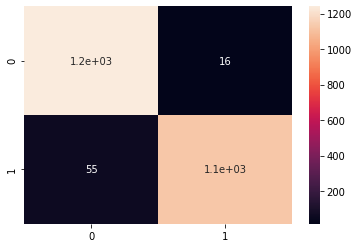

In [57]:
#Decision Tree  model
model_dt=Model("mushrooms.csv","class")
model_dt.create_X(["class", "gill-attachment", "gill-color", "gill-size", "habitat", "ring-type", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                      "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "spore-print-color", "odor"])
model_dt.categories_normalization()
model_dt.data_encoder(OneHotEncoder)
model_dt.choose_model('dt', params = {'max_depth': 11, 'min_samples_leaf': 1})
model_dt.split(0.3)
model_dt.run_model()
model_dt.matrix()

In [55]:
model_dt.grid_search_best(params={'max_depth':list(range(1,101,5)),
            'min_samples_leaf':list(range(1,20,1)),
           })

Fitting 5 folds for each of 380 candidates, totalling 1900 fits


{'max_depth': 11, 'min_samples_leaf': 1}

In [58]:
model_dt.model_explore()

Preparation of a new explainer is initiated

  -> data              : 5686 rows 28 cols
  -> target variable   : 5686 values
  -> model_class       : sklearn.tree._classes.DecisionTreeClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000294CD69F048> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.481, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.932, mean = -1.84e-18, max = 0.923
  -> model_info        : package sklearn

A new explainer has been created!


(            variable  dropout_loss                   label
 0       _full_model_      0.000910  DecisionTreeClassifier
 1          bruises_t      0.000910  DecisionTreeClassifier
 2        cap-color_e      0.000910  DecisionTreeClassifier
 3       population_a      0.000910  DecisionTreeClassifier
 4     gill-spacing_w      0.000910  DecisionTreeClassifier
 5      cap-surface_g      0.000910  DecisionTreeClassifier
 6       population_n      0.001129  DecisionTreeClassifier
 7    cap-shape_other      0.001196  DecisionTreeClassifier
 8       population_s      0.002050  DecisionTreeClassifier
 9        cap-color_g      0.002788  DecisionTreeClassifier
 10       cap-shape_s      0.003142  DecisionTreeClassifier
 11       cap-shape_x      0.003976  DecisionTreeClassifier
 12     ring-number_n      0.005057  DecisionTreeClassifier
 13     cap-surface_f      0.005912  DecisionTreeClassifier
 14       cap-color_y      0.006438  DecisionTreeClassifier
 15     cap-surface_y      0.010242  Dec